In [1]:
import numpy as np
import os
import sys
from ultralytics import YOLO
from PIL import Image
import torch
from torch import tensor
from torchvision.transforms import transforms, InterpolationMode
import timm
import torch.nn as nn
import pandas as pd

/media/plk/TOSHIBA EXT/mgr/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
DFPATH = 'models'
DFYOLO_NAME = "deepfaune-yolov8s_960"
BACKBONE = "vit_large_patch14_dinov2.lvd142m"
DFYOLO_WEIGHTS = os.path.join(DFPATH,'deepfaune-yolov8s_960.pt')
DFVIT_WEIGHTS = os.path.join(DFPATH,'deepfaune-vit_large_patch14_dinov2.lvd142m.v4.pt')

#### Setup

In [3]:
CROP_SIZE = 560 # default 182, has to be divisible by 14, 280?
DFYOLO_WIDTH = 960 # image width
DFYOLO_THRES = 0.6
DFYOLOHUMAN_THRES = 0.4 # boxes with human above this threshold are saved
DFYOLOCOUNT_THRES = 0.6

txt_animalclasses = {
   'en': ['bison', 'badger', 'ibex', 'beaver', 'red deer', 'golden jackal',
          'chamois', 'cat', 'goat', 'roe deer', 'dog', 'raccoon dog',
          'fallow deer', 'squirrel', 'moose', 'equid', 'genet', 'wolverine',
          'hedgehog', 'lagomorph', 'wolf', 'otter', 'lynx', 'marmot',
          'micromammal', 'mouflon', 'sheep', 'mustelid', 'bird', 'bear',
          'porcupine', 'nutria', 'muskrat', 'raccoon', 'fox', 'reindeer',
          'wild boar', 'cow']
}
# 'pl': ['żubr', 'borsuk', 'koziorożec', 'bóbr', 'jeleń szlachetny', 'szakal', 'kozica',
#           'kot', 'koza', 'sarna', 'pies', 'daniel', 'wiewiórka', 'łoś',
#           'koniowaty', 'żeneta', 'rosomak', 'jeż', 'zajęczak', 'wilk', 'wydra',
#           'ryś', 'świstak', 'mikrozwierzę', 'muflon', 'owca', 'łasica', 'ptak',
#           'niedźwiedź', 'nutria', 'szop', 'lis', 'renifer', 'dzik', 'krowa', 'jeżozwierz', 'piżmak']
# TODO


class Detector:
    def __init__(self, name=DFYOLO_NAME, threshold=None, countthreshold=None, humanthreshold=None):
        print("Using "+DFYOLO_NAME+" with weights at "+DFYOLO_WEIGHTS+", in resolution 960x960")
        self.yolo = YOLO(DFYOLO_WEIGHTS)
        self.imgsz = DFYOLO_WIDTH
        self.threshold = DFYOLO_THRES if threshold is None else threshold
        self.countthreshold = DFYOLOCOUNT_THRES if countthreshold is None else countthreshold
        self.humanthreshold = DFYOLOHUMAN_THRES if humanthreshold is None else humanthreshold

    def bestBoxDetection(self, filename_or_imagecv):
        try:
            results = self.yolo(filename_or_imagecv, verbose=False, imgsz=self.imgsz)
        except FileNotFoundError:
            print(f"File '{filename_or_imagecv}' not found")
            return None, 0, np.zeros(4), 0, []
        except Exception as err:
            print(err)
            return None, 0, np.zeros(4), 0, []

        # orig_img a numpy array (cv2) in BGR
        imagecv = results[0].cpu().orig_img
        detection = results[0].cpu().numpy().boxes

        # Are there any relevant boxes?
        if not len(detection.cls) or detection.conf[0] < self.threshold:
            # No. Image considered as empty
            return None, 0, np.zeros(4), 0, []
        else:
            # Yes. Non empty image
            pass
        # Is there a relevant animal box? 
        try:
            # Yes. Selecting the best animal box
            kbox = np.where((detection.cls==0) & (detection.conf>self.threshold))[0][0]
        except IndexError:
            # No: Selecting the best box for another category (human, vehicle)
            kbox = 0

        # categories are 1=animal, 2=person, 3=vehicle and the empty category 0=empty
        category = int(detection.cls[kbox]) + 1
        box = detection.xyxy[kbox] # xmin, ymin, xmax, ymax

        # Is this an animal box ?
        if category == 1:
            # Yes: cropped image is required for classification
            croppedimage = cropSquareCVtoPIL(imagecv, box.copy())
        else: 
            # No: return none
            return None, 0, np.zeros(4), 0, []
        
        ## animal count
        if category == 1:
            count = sum((detection.conf>self.countthreshold) & (detection.cls==0)) # only above a threshold
        else:
            count = 0
        ## human boxes
        ishuman = (detection.cls==1) & (detection.conf>=self.humanthreshold)
        if any(ishuman==True):
            humanboxes = detection.xyxy[ishuman,]
        else:
            humanboxes = []

        return croppedimage, category, box, count, humanboxes


def cropSquareCVtoPIL(imagecv, box):
    x1, y1, x2, y2 = box
    xsize = (x2-x1)
    ysize = (y2-y1)
    if xsize>ysize:
        y1 = y1-int((xsize-ysize)/2)
        y2 = y2+int((xsize-ysize)/2)
    if ysize>xsize:
        x1 = x1-int((ysize-xsize)/2)
        x2 = x2+int((ysize-xsize)/2)
    height, width, _ = imagecv.shape
    croppedimagecv = imagecv[max(0,int(y1)):min(int(y2),height),max(0,int(x1)):min(int(x2),width)]
    croppedimage = Image.fromarray(croppedimagecv[:,:,(2,1,0)]) # converted to PIL BGR image
    return croppedimage


class Classifier:

    def __init__(self):
        self.model = Model()
        self.model.loadWeights(DFVIT_WEIGHTS)
        # transform image to form usable by network
        self.transforms = transforms.Compose([
            transforms.Resize(size=(CROP_SIZE, CROP_SIZE), interpolation=InterpolationMode.BICUBIC, max_size=None, antialias=None),
            transforms.ToTensor(),
            transforms.Normalize(mean=tensor([0.4850, 0.4560, 0.4060]), std=tensor([0.2290, 0.2240, 0.2250]))])

    def predictOnBatch(self, batchtensor, withsoftmax=True):
        return self.model.predict(batchtensor, withsoftmax)

    # croppedimage loaded by PIL
    def preprocessImage(self, croppedimage):
        preprocessimage = self.transforms(croppedimage)
        return preprocessimage.unsqueeze(dim=0)


class Model(nn.Module):
    def __init__(self):
        """
        Constructor of model classifier
        """
        super().__init__()
        self.base_model = timm.create_model(BACKBONE, pretrained=False, num_classes=len(txt_animalclasses['en']),
                                            dynamic_img_size=True)
        print(f"Using {BACKBONE} with weights at {DFVIT_WEIGHTS}, in resolution {CROP_SIZE}x{CROP_SIZE}")
        self.backbone = BACKBONE
        self.nbclasses = len(txt_animalclasses['en'])

    def forward(self, input):
        x = self.base_model(input)
        return x

    def predict(self, data, withsoftmax=True):
        """
        Predict on test DataLoader
        :param test_loader: test dataloader: torch.utils.data.DataLoader
        :return: numpy array of predictions without soft max
        """
        self.eval()
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.to(device)
        total_output = []
        with torch.no_grad():
            x = data.to(device)
            if withsoftmax:
                output = self.forward(x).softmax(dim=1)
            else:
                output = self.forward(x)
            total_output += output.tolist()

        return np.array(total_output)

    def loadWeights(self, path):
        """
        :param path: path of .pt save of model
        """
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        print("CUDA available" if torch.cuda.is_available() else "CUDA unavailable. Using CPU")

        try:
            params = torch.load(path, map_location=device, weights_only=False)
            args = params['args']
            if self.nbclasses != args['num_classes']:
                raise Exception("You load a model ({}) that does not have the same number of class"
                                "({})".format(args['num_classes'], self.nbclasses))
            self.backbone = args['backbone']
            self.nbclasses = args['num_classes']
            self.load_state_dict(params['state_dict'])
        except Exception as e:
            print("Can't load checkpoint model because :\n\n " + str(e), file=sys.stderr)
            raise e


#### Detect animal and crop image

In [53]:
IMAGES_PATH = '../../pictures/08_CZYSTOGARB/B/Lato/2/'
IMAGE_FILE = '2023-07-17 20-48-24.JPG'
IMAGE_PATH = IMAGES_PATH + IMAGE_FILE

det = Detector()

Using deepfaune-yolov8s_960 with weights at models/deepfaune-yolov8s_960.pt, in resolution 960x960


In [54]:
croppedimage, category, box, count, humanboxes = det.bestBoxDetection(IMAGE_PATH)

Image here is still big

#### Classify animal

In [55]:
classifier = Classifier()

Using vit_large_patch14_dinov2.lvd142m with weights at models/deepfaune-vit_large_patch14_dinov2.lvd142m.v4.pt, in resolution 560x560
CUDA available


In [56]:
cropped_tensor = torch.ones((1,3,CROP_SIZE,CROP_SIZE))
cropped_tensor[0,:,:,:] =  classifier.preprocessImage(croppedimage)
scores = classifier.model.predict(cropped_tensor)
scores

array([[ 2.2498e-06,  2.9331e-06,  2.8294e-06,  3.9971e-06,  7.6311e-06,  9.9209e-06,  1.6024e-06,  0.00010547,  1.4596e-05,  1.0276e-05,  1.5422e-05,   1.076e-05,  2.0871e-06,  5.1336e-06,  1.1234e-05,   1.012e-06,  3.3339e-05,  5.4318e-06,  1.3989e-06,  7.7259e-06,  4.0932e-06,  2.5115e-06,     0.99964,
         8.8029e-07,   3.431e-06,  1.3685e-06,  1.8991e-06,  9.2729e-06,  6.2021e-06,  1.0418e-05,  1.8977e-06,  2.1094e-05,  8.4796e-07,  1.6212e-06,  1.8961e-05,  1.6373e-06,  8.7422e-06,  1.1793e-05]])

In [58]:
output = pd.DataFrame({'species':txt_animalclasses['en'], 'score':scores[0][:]})
output = output[output['score'] > 0.2]

In [59]:
print(f"Wykryto zwierzę: {output.loc[output['score'].idxmax(), 'species']}")

Wykryto zwierzę: lynx



(eog:16505): Gtk-WARNING **: 08:49:08.322: Theme file for DMZ-Black has no directories


#### Pipeline klasyfikacji

In [4]:
def show_cropped_image(x: torch.Tensor):
    # Remove batch dimension
    x = x.squeeze(0)

    # Unnormalize
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
    x = x * std + mean

    # Clamp to valid range [0, 1]
    x = x.clamp(0, 1)

    # Convert to PIL
    to_pil = transforms.ToPILImage()
    img = to_pil(x)

    display(img)

In [5]:
detector = Detector()
classifier = Classifier()

Using deepfaune-yolov8s_960 with weights at models/deepfaune-yolov8s_960.pt, in resolution 960x960
Using vit_large_patch14_dinov2.lvd142m with weights at models/deepfaune-vit_large_patch14_dinov2.lvd142m.v4.pt, in resolution 560x560
CUDA unavailable. Using CPU


/media/plk/TOSHIBA EXT/mgr/.venv/lib/python3.12/site-packages/torch/cuda/__init__.py:182: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at /pytorch/c10/cuda/CUDAFunctions.cpp:119.)
  return torch._C._cuda_getDeviceCount() > 0


    species     score
9  roe deer  0.994414

Wykryto zwierzę: roe deer


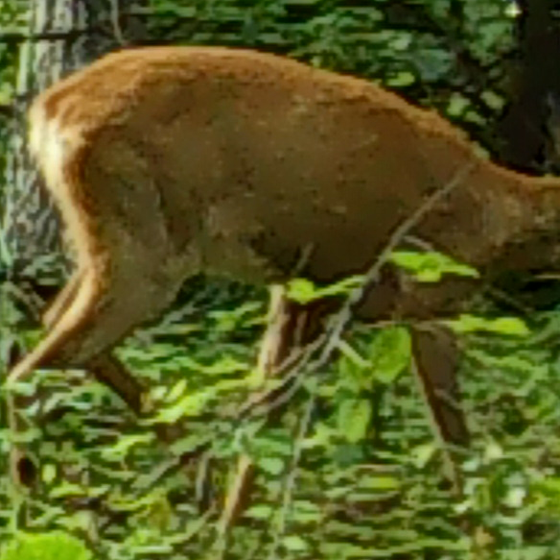

In [6]:
IMAGES_PATH = '../../pictures/02_WYSZOWATKA/B/Lato/2/'
IMAGE_FILE = '2023-07-22 19-22-33.JPG'
IMAGE_PATH = IMAGES_PATH + IMAGE_FILE

croppedimage, category, box, count, humanboxes = detector.bestBoxDetection(IMAGE_PATH)
if croppedimage is not None:
    cropped_tensor = torch.ones((1,3,CROP_SIZE,CROP_SIZE))
    cropped_tensor[0,:,:,:] =  classifier.preprocessImage(croppedimage)
    scores = classifier.model.predict(cropped_tensor)
    output = pd.DataFrame({'species':txt_animalclasses['en'], 'score':scores[0][:]})
    output = output[output['score'] > 0.2]
    print(output)

    print(f"\nWykryto zwierzę: {output.loc[output['score'].idxmax(), 'species']}")
    show_cropped_image(cropped_tensor)
else:
    print('Nie wykryto zwierzęcia')

#### Pętla klasyfikacji

In [95]:
from datetime import datetime
detector = Detector()
classifier = Classifier()

Using deepfaune-yolov8s_960 with weights at models/deepfaune-yolov8s_960.pt, in resolution 960x960
Using vit_large_patch14_dinov2.lvd142m with weights at models/deepfaune-vit_large_patch14_dinov2.lvd142m.v4.pt, in resolution 560x560
CUDA available


Below code executed in 255 minutes 7 seconds

In [98]:
images = pd.read_csv('../y_clean.csv', index_col=0)
images.RelativePath = images.RelativePath.str.replace('\\', '/')
results = pd.DataFrame({'image': [], 'detected_animal': []})
currently_classifying = images.iloc[0,1].rsplit('/')[0]
print('Currently: ' + currently_classifying)

for _, row in images.iterrows():
    if currently_classifying != row['RelativePath'].rsplit('/')[0]:
        currently_classifying = row['RelativePath'].rsplit('/')[0]
        print('Currently: ' + currently_classifying)
    image_path = '../../pictures/' + row['RelativePath'] + '/' + row['File']
    croppedimage, category, box, count, humanboxes = detector.bestBoxDetection(image_path)

    if croppedimage is not None:
        cropped_tensor = torch.ones((1,3,CROP_SIZE,CROP_SIZE))
        cropped_tensor[0,:,:,:] =  classifier.preprocessImage(croppedimage)
        scores = classifier.model.predict(cropped_tensor)
        output = pd.DataFrame({'species':txt_animalclasses['en'], 'score':scores[0][:]})
        output = output[output['score'] > 0.1]

        if output.empty:
            results.loc[len(results)] = [image_path, 'empty']
        else:
            results.loc[len(results)] = [image_path, output.loc[output['score'].idxmax(), 'species']]
    else:
        results.loc[len(results)] = [image_path, 'empty']

now = datetime.now().strftime('%Y_%m_%d_%H_%M')
results.to_csv('results/results_deepfaune' + now + '.csv')

Currently: 01_CZARNE
File '../../pictures/01_CZARNE/R/Późna jesień/1/2022-11-27 20-44-11.JPG' not found
File '../../pictures/01_CZARNE/R/Późna jesień/1/2022-12-01 06-50-24.JPG' not found
File '../../pictures/01_CZARNE/R/Późna jesień/1/2022-12-01 06-50-31.JPG' not found
File '../../pictures/01_CZARNE/R/Późna jesień/1/2022-12-08 15-02-31.JPG' not found
File '../../pictures/01_CZARNE/R/Późna jesień/1/2022-12-08 15-03-02.JPG' not found
File '../../pictures/01_CZARNE/R/Późna jesień/1/2022-12-08 15-03-12.JPG' not found
File '../../pictures/01_CZARNE/R/Późna jesień/1/2022-12-08 15-03-20.JPG' not found
File '../../pictures/01_CZARNE/R/Późna jesień/1/2022-12-08 15-03-28.JPG' not found
File '../../pictures/01_CZARNE/R/Późna jesień/1/2022-12-08 15-03-35.JPG' not found
File '../../pictures/01_CZARNE/R/Późna jesień/1/2022-12-08 15-03-43.JPG' not found
File '../../pictures/01_CZARNE/R/Późna jesień/1/2022-12-08 15-03-50.JPG' not found
File '../../pictures/01_CZARNE/R/Późna jesień/1/2022-12-08 15-04-0

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 63 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 230 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 32 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 344 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 12 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: pre

WARNING ⚠️ Image Read Error /media/plk/TOSHIBA EXT/mgr/deepfaune/../../pictures/10_ŁUPKÓW/B/Późna jesień/2/2022-11-24 21-23-57.JPG
need at least one array to stack


Corrupt JPEG data: 7178 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 72 extraneous bytes before marker 0xd9
Corrupt JPEG data: 17 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


Currently: 11_ZUBEŃSKO


Corrupt JPEG data: 2242 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


Currently: 12_BALNICA
File '../../pictures/12_BALNICA/B/Późna jesień/1/2022-11-27 08-48-00.JPG' not found
File '../../pictures/12_BALNICA/B/Późna jesień/1/2022-11-27 08-48-07.JPG' not found
File '../../pictures/12_BALNICA/B/Późna jesień/1/2022-11-27 08-49-09.JPG' not found
File '../../pictures/12_BALNICA/B/Późna jesień/1/2022-11-27 08-52-30.JPG' not found
File '../../pictures/12_BALNICA/B/Późna jesień/1/2022-12-01 08-47-44.JPG' not found
File '../../pictures/12_BALNICA/B/Późna jesień/1/2022-12-01 08-48-04.JPG' not found
File '../../pictures/12_BALNICA/B/Późna jesień/1/2022-12-01 08-48-26.JPG' not found
File '../../pictures/12_BALNICA/B/Późna jesień/1/2022-12-01 08-48-36.JPG' not found
File '../../pictures/12_BALNICA/B/Późna jesień/1/2022-12-01 08-48-43.JPG' not found
File '../../pictures/12_BALNICA/B/Późna jesień/1/2022-12-01 08-48-50.JPG' not found
File '../../pictures/12_BALNICA/B/Późna jesień/1/2022-12-04 07-17-47.JPG' not found
File '../../pictures/12_BALNICA/B/Późna jesień/1/2022-

Corrupt JPEG data: premature end of data segment


Currently: 13_BANDRÓW
Currently: 14_JURECZKOWA
Currently: 15_PAPIERNIA
WARNING ⚠️ Image Read Error /media/plk/TOSHIBA EXT/mgr/deepfaune/../../pictures/15_PAPIERNIA/B/Lato/1/2023-08-04 02-49-21.JPG
need at least one array to stack
Currently: 16_HUTA_KOMOROWSKA
WARNING ⚠️ Image Read Error /media/plk/TOSHIBA EXT/mgr/deepfaune/../../pictures/16_HUTA_KOMOROWSKA/B/Lato/1/2023-07-08 08-12-33.JPG
need at least one array to stack
WARNING ⚠️ Image Read Error /media/plk/TOSHIBA EXT/mgr/deepfaune/../../pictures/16_HUTA_KOMOROWSKA/B/Lato/1/2023-07-10 04-21-24.JPG
need at least one array to stack
Currently: 17_ZAGAJE
WARNING ⚠️ Image Read Error /media/plk/TOSHIBA EXT/mgr/deepfaune/../../pictures/17_ZAGAJE/R/Lato/2/2023-07-29 20-33-3823.JPG
need at least one array to stack
WARNING ⚠️ Image Read Error /media/plk/TOSHIBA EXT/mgr/deepfaune/../../pictures/17_ZAGAJE/R/Lato/2/2023-07-29 20-34-0224.JPG
need at least one array to stack
WARNING ⚠️ Image Read Error /media/plk/TOSHIBA EXT/mgr/deepfaune/../../pi

In [92]:
now = datetime.now().strftime('%Y_%m_%d_%H_%M')
results.to_csv('results/results_deepfaune' + now + '.csv')
results

,image,detected_animal
0,2023-07-16 08-48-23.JPG,empty
1,2023-07-21 06-39-47.JPG,empty
2,2023-07-25 13-56-58.JPG,bird
3,2023-07-28 13-48-47.JPG,bird
4,2023-07-29 08-26-10.JPG,bird
...,...,...
108,2022-09-26 06-17-05.JPG,red deer
109,2022-09-26 06-17-13.JPG,red deer
110,2022-09-26 06-17-21.JPG,red deer
111,2022-09-26 06-17-34.JPG,red deer
